# DM-47942 Fake catalog creation of fake point sources for AP

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>Notebook to generate catalogs of fake point sources for AP</b> <br>
Contact author: Bruno Sánchez - Raphael Bonnet Guerrini<br>
Last verified to run: 4 Dec 2024<br>
LSST Science Piplines version: w_2024_47<br>

In [1]:
import numpy as np
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
from astropy import coordinates as coords
from astropy import units as u

from astropy.io import fits
from astropy.visualization import ZScaleInterval, SqrtStretch
from astropy.visualization import ImageNormalize, MinMaxInterval, LogStretch
from astropy.table import Table, join
import lsst.daf.butler as dafButler

In [69]:
from lsst.geom import Point2D, Box2I, Point2I, Extent2I

In [70]:
from lsst.analysis.ap import apdb
from lsst.analysis.ap import legacyPlotUtils as pla

In [71]:
from lsst import geom

In [72]:
import os

In [73]:
from astropy.visualization import LinearStretch, LogStretch, ZScaleInterval, MinMaxInterval, ImageNormalize

In [75]:
# repo="/sdf/group/rubin/repo/main/butler.yaml"
repo = "embargo_or4"
instrument = 'LSSTComCamSim'
collection = "u/sullii/DM-46333/OR4/databaseTimeoutFix_with_forcedSourceLimit"
collection = [collection, "skymaps", "LSSTComCamSim/templates", "LSSTComCamSim/runs/DRP/OR4/w_2024_25/DM-45066"]

In [76]:
butler = dafButler.Butler(repo, instrument=instrument, collections=collection) 

In [77]:
collection = "LSSTComCamSim/runs/DRP/OR4/w_2024_25/DM-45066"

In [78]:
skymap = 'ops_rehersal_prep_2k_v1'
skyMap = butler.get('skyMap', dataId=dict(skymap=skymap))

In [ ]:
# read the catalog: if not, create it
# df = pd.read_csv("dataIds_visitDet_coords_OR4_forFakes.csv")

In [79]:
if os.path.isfile('dataIds_visitDet_coords_OR4_forFakes.csv'):
    df = pd.read_csv("dataIds_visitDet_coords_OR4_forFakes.csv")
else:

    datarows = []
    for dataref in butler.registry.queryDatasets("initialPviSummary_metrics"):
        summ = butler.get(dataref)
        dataid = dict(dataref.dataId.to_simple())['dataId']
        dataid['ra'] = summ['initialPviSummaryMetrics'][5].quantity.value
        dataid['dec'] = summ['initialPviSummaryMetrics'][6].quantity.value

        datarows.append(dataid)

    df = pd.DataFrame(datarows)
    df.to_csv("dataIds_visitDet_coords_OR4_forFakes.csv", index=False)

In [80]:
OR4fields = (
    ("Rubin_SV_095_-25", 95., -25.), # High stellar densty, low extinction
    ("Rubin_SV_125_-15", 125., -15.), # High stellar densty, low extinction
    ("DESI_SV3_R1", 179.60, 0.000), # DESI, GAMA, HSC DR2, KiDS-N
    #(360 - 145., -25.),
    ("Rubin_SV_225_-40", 225., -40.), # 225 High stellar densty, low extinction
    ("DEEP_A0", 216, -12.5), # DEEP Solar Systen
    ("Rubin_SV_250_2", 250., 2.), # 250 High stellar densty, low extinction
    #(219.80, -0.600), # DESI, GAMA, HSC DR2, KiDS-N
    #(360 - 53., -25),
    #(270.891667, -30.033889), # Baade's Window
    ("Rubin_SV_300_-41", 300., -41.), # High stellar densty, low extinction 
    ("Rubin_SV_280_-48", 280., -48.), # High stellar densty, low extinction 
    ("DEEP_B0", 310, -19), # DEEP Solar System
    ("ELAIS_S1", 9.45, -44.0), # ELAIS-S1 LSST DDF
    ("XMM_LSS", 35.708333, -4.75), # LSST DDF
    ("ECDFS", 53.125, -28.1), # ECDFS
    ("COSMOS", 150.1, 2.1819444444444445), # COSMOS
    ("EDFS_A", 58.9, -49.315), # EDFS_a
    ("EDFS_B", 63.6, -47.6), # EDFS_b
)

In [81]:
or4_df = pd.DataFrame(OR4fields, columns=['FieldName', 'ra', 'dec'])

In [82]:
or4_df

,FieldName,ra,dec
0,Rubin_SV_095_-25,95.000000,-25.000000
1,Rubin_SV_125_-15,125.000000,-15.000000
2,DESI_SV3_R1,179.600000,0.000000
3,Rubin_SV_225_-40,225.000000,-40.000000
4,DEEP_A0,216.000000,-12.500000
5,Rubin_SV_250_2,250.000000,2.000000
6,Rubin_SV_300_-41,300.000000,-41.000000
7,Rubin_SV_280_-48,280.000000,-48.000000
8,DEEP_B0,310.000000,-19.000000
9,ELAIS_S1,9.450000,-44.000000


Text(0, 0.5, 'DEC')

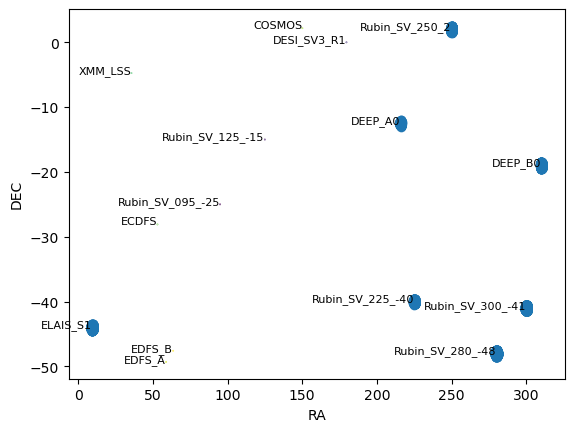

In [83]:
colors = plt.cm.viridis(np.linspace(0, 1, len(or4_df)))

plt.scatter(or4_df['ra'], or4_df['dec'], color=colors, s=0.1)

for ifield, afield in or4_df.iterrows():
    plt.text(afield.ra, afield.dec, afield.FieldName, fontsize=8, ha='right')

plt.plot(df.ra, df.dec, 'o', alpha=0.5)
plt.xlabel('RA')
plt.ylabel('DEC')
# plt.legend(loc='upper left')

Choose a field for the creation of the catalog.
We pick a field, and in it, some visits to use.

In [84]:
flt_ra = np.abs(df.ra - 300) < 0.035
flt_dec = np.abs(df.dec - (-41)) < 0.035
flt_flt = df.band == "r"
flt = flt_ra & flt_dec & flt_flt

subset_df = df[flt]
subset_df

,instrument,detector,visit,band,day_obs,physical_filter,ra,dec
1894,LSSTComCamSim,4,7024062500480,r,20240625,r_03,300.033166,-40.970161
5227,LSSTComCamSim,4,7024062600239,r,20240626,r_03,300.001277,-40.989559
8932,LSSTComCamSim,4,7024062600711,r,20240626,r_03,300.009404,-40.998422
9547,LSSTComCamSim,4,7024062600532,r,20240626,r_03,299.965037,-41.005411
9967,LSSTComCamSim,4,7024062600238,r,20240626,r_03,299.997498,-41.030974
10257,LSSTComCamSim,4,7024062700586,r,20240627,r_03,299.968349,-41.023797
10966,LSSTComCamSim,4,7024062600545,r,20240626,r_03,300.021312,-40.972992
14289,LSSTComCamSim,4,7024062500636,r,20240625,r_03,299.973966,-41.014219
17024,LSSTComCamSim,4,7024062500583,r,20240625,r_03,300.033166,-40.970161


In [85]:
# Just create a subset of the data to be used for fakes
subset_df.to_csv("subsetVisitsOR4_forFakes.csv", index=False)

## Create the fake catalog

In [86]:
#read the visit catalog, if not create it as below
vd_df = pd.read_csv("subsetVisitsOR4_forFakes.csv")

In [87]:
dataquery=f"exposure IN ({','.join([str(vsn) for vsn in df[flt].visit.unique()])}) AND detector in (4)"
dataquery

'exposure IN (7024062500480,7024062600239,7024062600711,7024062600532,7024062600238,7024062700586,7024062600545,7024062500636,7024062500583) AND detector in (4)'

In [88]:
vd_df

,instrument,detector,visit,band,day_obs,physical_filter,ra,dec
0,LSSTComCamSim,4,7024062500480,r,20240625,r_03,300.033166,-40.970161
1,LSSTComCamSim,4,7024062600239,r,20240626,r_03,300.001277,-40.989559
2,LSSTComCamSim,4,7024062600711,r,20240626,r_03,300.009404,-40.998422
3,LSSTComCamSim,4,7024062600532,r,20240626,r_03,299.965037,-41.005411
4,LSSTComCamSim,4,7024062600238,r,20240626,r_03,299.997498,-41.030974
5,LSSTComCamSim,4,7024062700586,r,20240627,r_03,299.968349,-41.023797
6,LSSTComCamSim,4,7024062600545,r,20240626,r_03,300.021312,-40.972992
7,LSSTComCamSim,4,7024062500636,r,20240625,r_03,299.973966,-41.014219
8,LSSTComCamSim,4,7024062500583,r,20240625,r_03,300.033166,-40.970161


In [89]:
vn = vd_df.loc[0, 'visit']
dn = vd_df.loc[0, 'detector']
ba = vd_df.loc[0, 'band']

In [90]:
butler.registry.queryDatasetTypes('sourceTable')

[DatasetType('sourceTable', {band, instrument, day_obs, detector, physical_filter, visit}, DataFrame)]

In [91]:
list(butler.registry.queryDatasets('sourceTable'))[:5]

[DatasetRef(DatasetType('sourceTable', {band, instrument, day_obs, detector, physical_filter, visit}, DataFrame), {instrument: 'LSSTComCamSim', detector: 5, visit: 7024062700297, band: 'r', day_obs: 20240627, physical_filter: 'r_03'}, run='LSSTComCamSim/runs/DRP/OR4/w_2024_25/DM-45066/20240629T015223Z', id=1e2d9253-4576-478f-862c-42b22c14c394),
 DatasetRef(DatasetType('sourceTable', {band, instrument, day_obs, detector, physical_filter, visit}, DataFrame), {instrument: 'LSSTComCamSim', detector: 6, visit: 7024062700504, band: 'g', day_obs: 20240627, physical_filter: 'g_01'}, run='LSSTComCamSim/runs/DRP/OR4/w_2024_25/DM-45066/20240629T015223Z', id=57c54b63-f257-42e7-937c-1b0e21e768df),
 DatasetRef(DatasetType('sourceTable', {band, instrument, day_obs, detector, physical_filter, visit}, DataFrame), {instrument: 'LSSTComCamSim', detector: 2, visit: 7024062500255, band: 'r', day_obs: 20240625, physical_filter: 'r_03'}, run='LSSTComCamSim/runs/DRP/OR4/w_2024_25/DM-45066/20240629T015223Z', i

In [92]:
sourceCat = butler.get('sourceTable', visit=vn, detector=dn, band=ba)

We use source catalogs like the above one to generate our fake positions and magnitudes

### Section of convenient functions for fake catalog creation

This has been developed by Raphael Bonnet Guerrini at CPPM (2024)

In [93]:
def calculate_orientation_and_extent(Ixx, Ixy, Iyy):
    '''
    Calculates the orientation and extent of an object based on its second moments.

    Parameters:
    Ixx (float): Second moment of the object along the x-axis. Often in degree²
    Ixy (float): Second moment of the object along the x and y-axes. Often in degree²
    Iyy (float): Second moment of the object along the y-axis. Often in degree²

    Returns:
    tuple: A tuple containing:
        - theta (float): The orientation angle of the object in radians.
        - a (float): The semi-major axis length of the object.
        - b (float): The semi-minor axis length of the object.
    '''
    # Calculate position angle (orientation)
    theta = 0.5 * np.arctan2(2 * Ixy, Ixx - Iyy)

    # Calculate eigenvalues of the moment matrix
    term1 = (Ixx + Iyy) / 2
    term2 = np.sqrt(((Ixx - Iyy) / 2) ** 2 + Ixy ** 2)
    lambda1 = term1 + term2
    lambda2 = term1 - term2

    a = np.sqrt(lambda1)
    b = np.sqrt(lambda2)

    return theta, a, b

In [94]:
def generate_fakes_pos_mag(single_detec):
    '''
    Generates fake positions and magnitudes of a fake supernova given galaxy second moment.

    Parameters:
    single_detec (dict): A dictionary containing the detection parameters.
                         Expected keys are 'ixx', 'ixy', 'iyy', and a 
                         flux key (default is 'calibFlux').

    Returns:
    tuple: A tuple containing:
        - r (float): The randomly generated radial distance from the center 
                    based on the semi-major axis length.
        - theta (float): The randomly generated orientation angle in degrees.
        - mag (float): The randomly generated magnitude in AB magnitudes.
        - orientation (float): The orientation angle of the object in radians.
    '''
    orientation, a, b = calculate_orientation_and_extent(
        single_detec['ixx'], single_detec['ixy'], single_detec['iyy'])

    # sample r ~ N(0,a) and sample theta randomly
    r = np.random.normal(0, a, size=1)
    theta = np.random.uniform(0, 180)

    # compute magnitude
    flux_type = 'calibFlux'   # can be changed

    flux = (np.array(single_detec[flux_type]))
    mag = (flux * u.nJy).to(u.ABmag)

    # dealing with infinite magnitude
    if np.isfinite(mag.value): 
        mag  = np.random.uniform(mag.value -1, mag.value + 2)
    else:
        mag = np.random.uniform(19, 24)

    return r, theta, mag, orientation

In [95]:

def pos_mag_4catalog(catalog_of_galaxies, image, additional_host_data=False):
    '''
    Generates positions and magnitudes for a catalog of galaxies, and optionally plots them on the image. 
    The plot is composed of circles, centered on the host galaxies, with crosses centered the injected object, 
    host and injection have matching colors. The stars represents the hostless injection. They represents around 5% of the injection.

    Parameters:
    catalog_of_galaxies (DataFrame): DataFrame containing the catalog of galaxies with their properties (source table).
    image (Image): The image object containing the WCS information, calexp for instance.
    plot (bool): If True, plot the galaxies on the image. Default is False.
    additional_host_data (bool): If True, include additional host data in the output. Default is False.

    Returns:
    tuple: A tuple containing:
        - inject_ra (list): List of RA coordinates for the injected fake sources.
        - inject_dec (list): List of Dec coordinates for the injected fake sources.
        - mags (list): List of magnitudes for the injected fake sources.
        - host_data (DataFrame, optional): DataFrame containing additional host data if requested.
    '''

    inject_ra = []
    inject_dec = []
    new_positions = []
    new_rand_positions = []
    mags = []
    host_data = pd.DataFrame()
    flux_type = 'calibFlux'   # can be change 

    # Retrieve sky origin and pixel origin from wcs
    wcs = image.getWcs()

    # sky_origin = wcs.pixelToSky(Point2D(0, 0))  # Convert origin pixel to sky coordinates

    # sky_origin_ra = sky_origin.getRa().asDegrees()
    # sky_origin_dec = sky_origin.getDec().asDegrees()

    # pixel_origin_x = wcs.getPixelOrigin().getX()
    # pixel_origin_y = wcs.getPixelOrigin().getY()

    pixel_scale = wcs.getPixelScale().asArcseconds()
    px_to_deg = pixel_scale/3600

    for index, detec in catalog_of_galaxies.iterrows():
        r, theta, mag, orientation = generate_fakes_pos_mag(detec)
        mags.append(mag)

        # Convert radial positions to RaDec
        ra = detec['ra']
        dec = detec['dec']

        ## Convert polar coordinates (r, theta) to Cartesian coordinates (x, y)
        x = r * np.cos(np.radians(theta))
        y = r * np.sin(np.radians(theta))

        ## Retrieve the right position removing the galaxy orientation
        x_rot = x * np.cos(orientation) - y * np.sin(orientation)
        y_rot = x * np.sin(orientation) + y * np.cos(orientation)

        ## compute the difference between the host and the injection
        delta_ra = (x_rot/np.cos(np.radians(dec)))*px_to_deg # need to convert from pixel/arcesc to degrees
        delta_dec = y_rot*px_to_deg

        ## retrieving the global ra dec position of the injection
        ra_i = ra - delta_ra 
        dec_i = dec - delta_dec

        # store the ra dec in list 
        inject_ra.append(float(ra_i))
        inject_dec.append(float(dec_i))
        new_positions.append((ra_i, dec_i, ra, dec))

        # optionnally store host and visit information for each injection
        if additional_host_data:
            flux = (np.array(detec[flux_type]))
            host_mag = (flux * u.nJy).to(u.ABmag)
            single_host_data = pd.DataFrame({"ra" : ra_i,
                                            "dec" : dec_i,
                                            "mag" : mag,
                                            "host_magnitude" : host_mag,
                                            "visit" : detec['visit'],
                                            "detector" : detec['detector'],
                                            "parent_index" : index,
                                            "band" : detec['band']
                                            })
            host_data = pd.concat([host_data, single_host_data], ignore_index=True)
    # generate hostless injection
    nbr_hostless = len(catalog_of_galaxies)//10    # ~5% of the injection
    mag_hostless = [np.random.uniform(17, 23) for i in range(nbr_hostless)]
    mags.extend(mag_hostless)
    # pick a random position on the ccd
    x = np.random.uniform(0, image.width , size=nbr_hostless)
    y = np.random.uniform(0, image.height, size=nbr_hostless)

    # convert those in ra dec
    ra, dec = image.wcs.pixelToSkyArray(x,y, degrees = True)

    inject_ra.extend(list(ra))
    inject_dec.extend(list(dec))
    new_rand_positions = [(r, d, xx, yy) for r, d, xx, yy in zip(ra, dec, x, y)]

    # add optionnal data to the hostless injection (None for host infos)

    if additional_host_data:
        single_host_data = pd.DataFrame(
            {"ra" : list(ra),
             "dec" : list(dec),
             "mag" : mag_hostless,
             "host_magnitude": [None] * len(ra),  # Defaulting to None
             "visit" : detec['visit'],
             "detector" : detec['detector'],
             "parent_index": [None] * len(ra),  # Defaulting to None
             "band" : detec['band']
         })

        host_data = pd.concat([host_data, single_host_data], ignore_index=True)

        return inject_ra, inject_dec, mags, host_data

    return inject_ra, inject_dec, mags


In [96]:
def create_catalog(dict_data, host_data=False):
    '''
    Creates a catalog from dictionary data, optionally including host galaxy data. 
    The short catalog fits the injection pipeline standard. 

    Parameters:
    dict_data (dict): Dictionary containing 'ra', 'dec', 'mag', and optionally
      'host_magnitude', 'visit', 'detector', 'parent_index', 'band'.
    host_data (bool, optional): Flag indicating whether to include host 
    galaxy data. Defaults to False.

    Returns:
    astropy.table.Table: Catalog table containing injection_id, ra, dec, 
    source_type, mag, and optionally host_magnitude, visit, detector, 
    parent_index, band.
    '''
    # reduce catalog, fitting injection pipeline standard
    if host_data is False:
        df = pd.DataFrame({ "injection_id" : np.arange(len(dict_data["ra"])), 
                           "ra" : dict_data["ra"], 
                           "dec" : dict_data["dec"],
                           "source_type" : "Star",
                           "mag" : dict_data["mag"]})
        fancy_catalog = Table.from_pandas(df)
        return fancy_catalog
    # reduce catalog, adding information on host and visit
    else :
        df = pd.DataFrame({ "injection_id" : np.arange(len(dict_data["ra"])), 
                           "ra" : dict_data["ra"], 
                           "dec" : dict_data["dec"],
                           "source_type" : "Star",
                           "mag" : dict_data["mag"],
                          "host_magnitude" : dict_data["host_magnitude"],
                          "visit" : dict_data["visit"],
                          "detector" : dict_data["detector"],
                          "parent_index" : dict_data["parent_index"],
                          "band" : dict_data["band"],
                          })
        fancy_catalog = Table.from_pandas(df)
        return fancy_catalog

In [101]:
def create_catalog_for_all_ccd(datasetRefs, butler, csv=False, save_filename=None):

    all_catalog = pd.DataFrame()

    for i,reference in enumerate(datasetRefs):
        ref = reference.dataId

        detecs = butler.get('sourceTable', dataId=ref)
        calexp = butler.get('calexp', dataId=ref)

        filtered_detecs = detecs[detecs['extendedness'] == 1]
        # Sample n rows from the filtered DataFrame
        nbr_fake = int(len(filtered_detecs)/30)

        sampled_detecs = filtered_detecs.sample(n=nbr_fake, random_state=42)
        finite_mag_per = sum(
            np.isfinite((flux * u.nJy).to(u.ABmag).value) for flux in sampled_detecs['calibFlux']
            )/len(sampled_detecs)*100
        print(ref)
        print('nbr of galaxy : %d nbr of injection : %d percentage of real mag : %d' % (
            len(filtered_detecs), nbr_fake, finite_mag_per))

        ra, dec, mags, df = pos_mag_4catalog(sampled_detecs, calexp, True)

        fancy_catalog = create_catalog(df, True).to_pandas()
        all_catalog = pd.concat([all_catalog, fancy_catalog], ignore_index=True)

    if csv :
        all_catalog.to_csv(f'injection_catalog/{save_filename}.csv')


    return all_catalog

Make the dataquery to obtain the datarefs for catalog creation

In [102]:
drefs = butler.query_datasets('sourceTable', where=dataquery)

In [103]:
create_catalog_for_all_ccd?

Signature:
create_catalog_for_all_ccd(
    datasetRefs,
    butler,
    csv=False,
    save_filename=None,
)
Docstring: <no docstring>
File:      /lscratch/bos/ipykernel_2724945/842495863.py
Type:      function

In [104]:
fakeCat = create_catalog_for_all_ccd(drefs, butler)

{instrument: 'LSSTComCamSim', detector: 4, visit: 7024062500480, band: 'r', day_obs: 20240625, physical_filter: 'r_03'}
nbr of galaxy : 1306 nbr of injection : 43 percentage of real mag : 100


/lscratch/bos/ipykernel_2724945/1581045440.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inject_ra.append(float(ra_i))
/lscratch/bos/ipykernel_2724945/1581045440.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inject_dec.append(float(dec_i))
/lscratch/bos/ipykernel_2724945/1581045440.py:115: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  host_data = pd.concat([host_data, single_host

{instrument: 'LSSTComCamSim', detector: 4, visit: 7024062500583, band: 'r', day_obs: 20240625, physical_filter: 'r_03'}
nbr of galaxy : 1293 nbr of injection : 43 percentage of real mag : 100


/lscratch/bos/ipykernel_2724945/1581045440.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inject_ra.append(float(ra_i))
/lscratch/bos/ipykernel_2724945/1581045440.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inject_dec.append(float(dec_i))
/lscratch/bos/ipykernel_2724945/1581045440.py:115: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  host_data = pd.concat([host_data, single_host

{instrument: 'LSSTComCamSim', detector: 4, visit: 7024062500636, band: 'r', day_obs: 20240625, physical_filter: 'r_03'}
nbr of galaxy : 1290 nbr of injection : 43 percentage of real mag : 97
{instrument: 'LSSTComCamSim', detector: 4, visit: 7024062600238, band: 'r', day_obs: 20240626, physical_filter: 'r_03'}
nbr of galaxy : 1993 nbr of injection : 66 percentage of real mag : 100


/lscratch/bos/ipykernel_2724945/1581045440.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inject_ra.append(float(ra_i))
/lscratch/bos/ipykernel_2724945/1581045440.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inject_dec.append(float(dec_i))
/lscratch/bos/ipykernel_2724945/1581045440.py:115: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  host_data = pd.concat([host_data, single_host

{instrument: 'LSSTComCamSim', detector: 4, visit: 7024062600239, band: 'r', day_obs: 20240626, physical_filter: 'r_03'}
nbr of galaxy : 1972 nbr of injection : 65 percentage of real mag : 100


/lscratch/bos/ipykernel_2724945/1581045440.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inject_ra.append(float(ra_i))
/lscratch/bos/ipykernel_2724945/1581045440.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inject_dec.append(float(dec_i))
/lscratch/bos/ipykernel_2724945/1581045440.py:115: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  host_data = pd.concat([host_data, single_host

{instrument: 'LSSTComCamSim', detector: 4, visit: 7024062600532, band: 'r', day_obs: 20240626, physical_filter: 'r_03'}
nbr of galaxy : 1906 nbr of injection : 63 percentage of real mag : 98


/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/lscratch/bos/ipykernel_2724945/1581045440.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inject_ra.append(float(ra_i))
/lscratch/bos/ipykernel_2724945/1581045440.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inject_dec.append(float(dec_i))
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log1

{instrument: 'LSSTComCamSim', detector: 4, visit: 7024062600545, band: 'r', day_obs: 20240626, physical_filter: 'r_03'}
nbr of galaxy : 1912 nbr of injection : 63 percentage of real mag : 98
{instrument: 'LSSTComCamSim', detector: 4, visit: 7024062600711, band: 'r', day_obs: 20240626, physical_filter: 'r_03'}
nbr of galaxy : 1394 nbr of injection : 46 percentage of real mag : 100


/lscratch/bos/ipykernel_2724945/1581045440.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inject_ra.append(float(ra_i))
/lscratch/bos/ipykernel_2724945/1581045440.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inject_dec.append(float(dec_i))
/lscratch/bos/ipykernel_2724945/1581045440.py:115: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  host_data = pd.concat([host_data, single_host

{instrument: 'LSSTComCamSim', detector: 4, visit: 7024062700586, band: 'r', day_obs: 20240627, physical_filter: 'r_03'}
nbr of galaxy : 2330 nbr of injection : 77 percentage of real mag : 97


/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/lscratch/bos/ipykernel_2724945/1581045440.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inject_ra.append(float(ra_i))
/lscratch/bos/ipykernel_2724945/1581045440.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inject_dec.append(float(dec_i))
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log1

In [105]:
fakeCat

,injection_id,ra,dec,source_type,mag,host_magnitude,visit,detector,parent_index,band
0,0,299.915922,-40.970850,Star,20.667254,20.864039,7024062500480,4,3068394420907805916,r
1,1,299.911491,-40.952888,Star,24.815846,22.897936,7024062500480,4,3068394420907804056,r
2,2,300.095868,-41.066437,Star,23.324256,21.467599,7024062500480,4,3068394420907804921,r
3,3,299.925144,-41.030604,Star,21.784846,21.561938,7024062500480,4,3068394420907804948,r
4,4,300.107628,-41.098121,Star,24.024841,22.951206,7024062500480,4,3068394420907806195,r
...,...,...,...,...,...,...,...,...,...,...
551,79,299.941934,-40.994375,Star,22.300014,NaN,7024062700586,4,NaN,r
552,80,299.976318,-41.105279,Star,21.672429,NaN,7024062700586,4,NaN,r
553,81,300.075708,-41.050628,Star,18.833793,NaN,7024062700586,4,NaN,r
554,82,300.038202,-41.048437,Star,21.301468,NaN,7024062700586,4,NaN,r


Visualize some of the catalog 

In [106]:
summaries = []
for avisitRef in drefs:
    finalSumm = butler.get('finalVisitSummary', avisitRef.dataId)
    summaries.append(finalSumm.asAstropy()[4])

In [107]:
len(summaries)

9

In [108]:
from astropy.table import vstack
summaries = vstack(summaries)

In [109]:
len(summaries)

9

In [110]:
summ_df = summaries[
    ['id','bbox_min_x','bbox_min_y','bbox_max_x','bbox_max_y','visit',
     'physical_filter','band','psfSigma','psfArea','ra','dec',
     'zenithDistance','pixelScale','expTime','zeroPoint']
].to_pandas()

In [111]:
len(summ_df)

9

In [112]:
ra_corner_0 = summaries['raCorners'].value[:,0]
ra_corner_1 = summaries['raCorners'].value[:,1]
ra_corner_2 = summaries['raCorners'].value[:,2]
ra_corner_3 = summaries['raCorners'].value[:,3]

dec_corner_0 = summaries['decCorners'].value[:,0]
dec_corner_1 = summaries['decCorners'].value[:,1]
dec_corner_2 = summaries['decCorners'].value[:,2]
dec_corner_3 = summaries['decCorners'].value[:,3]

In [113]:
summ_df['ccd_corner_1_ra'] = ra_corner_0
summ_df['ccd_corner_2_ra'] = ra_corner_1
summ_df['ccd_corner_3_ra'] = ra_corner_2
summ_df['ccd_corner_4_ra'] = ra_corner_3

In [114]:
summ_df['ccd_corner_1_dec'] = dec_corner_0
summ_df['ccd_corner_2_dec'] = dec_corner_1
summ_df['ccd_corner_3_dec'] = dec_corner_2
summ_df['ccd_corner_4_dec'] = dec_corner_3

In [115]:
len(drefs)

9

In [116]:
colors

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.28291 , 0.105393, 0.426902, 1.      ],
       [0.275191, 0.194905, 0.496005, 1.      ],
       [0.248629, 0.278775, 0.534556, 1.      ],
       [0.212395, 0.359683, 0.55171 , 1.      ],
       [0.180629, 0.429975, 0.557282, 1.      ],
       [0.153364, 0.497   , 0.557724, 1.      ],
       [0.127568, 0.566949, 0.550556, 1.      ],
       [0.122312, 0.633153, 0.530398, 1.      ],
       [0.175707, 0.6979  , 0.491033, 1.      ],
       [0.288921, 0.758394, 0.428426, 1.      ],
       [0.449368, 0.813768, 0.335384, 1.      ],
       [0.626579, 0.854645, 0.223353, 1.      ],
       [0.814576, 0.883393, 0.110347, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ]])

/lscratch/bos/ipykernel_2724945/1753647171.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(visitFakes['ra'], visitFakes['dec'], c=colors[irow], s=50*sizes**2)


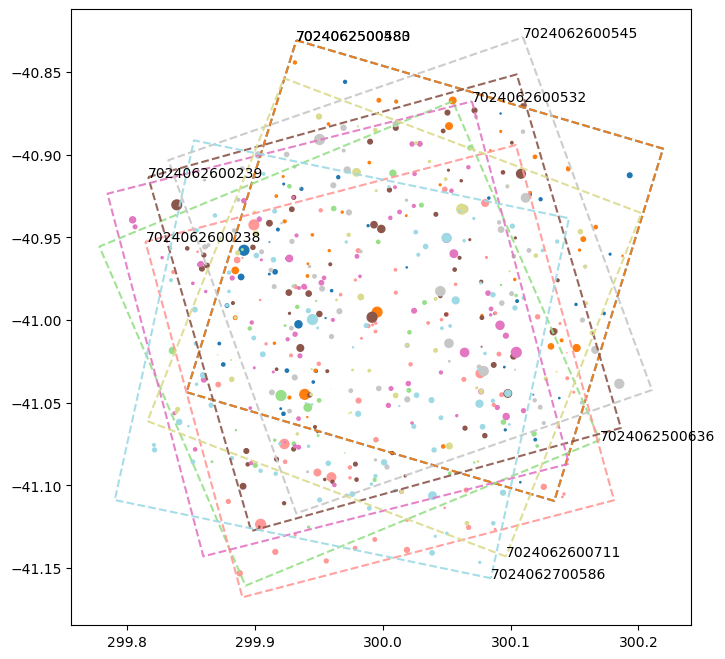

In [117]:
colors = plt.cm.tab20(np.linspace(0, 1, len(summ_df)))

fig, ax = plt.subplots(1, 1, figsize=(8,8))
# plt.grid()
for irow, arow in summ_df.iterrows():    
    verts = (
        [arow['ccd_corner_1_ra'], arow['ccd_corner_1_dec']],
        [arow['ccd_corner_2_ra'], arow['ccd_corner_2_dec']],
        [arow['ccd_corner_3_ra'], arow['ccd_corner_3_dec']],
        [arow['ccd_corner_4_ra'], arow['ccd_corner_4_dec']],
        [arow['ccd_corner_1_ra'], arow['ccd_corner_1_dec']]   # repeat to close loop
    )

    rough_center = np.mean(np.array(verts), axis=0)

    xs, ys = zip(*verts)
    ax.plot(xs, ys, '--', color=colors[irow], alpha=0.9)
    
    ax.text(arow['ccd_corner_1_ra'], arow['ccd_corner_1_dec'], arow['visit'], alpha=1)
    visitFakes = fakeCat[fakeCat.visit==arow['visit']]
    sizes = (visitFakes['mag'] - visitFakes['mag'].max())/(visitFakes['mag'].max() - visitFakes['mag'].min())
    plt.scatter(visitFakes['ra'], visitFakes['dec'], c=colors[irow], s=50*sizes**2)

/lscratch/bos/ipykernel_2724945/2357990337.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(visitFakes['ra'], visitFakes['dec'], c=colors[irow], s=50*sizes**2)


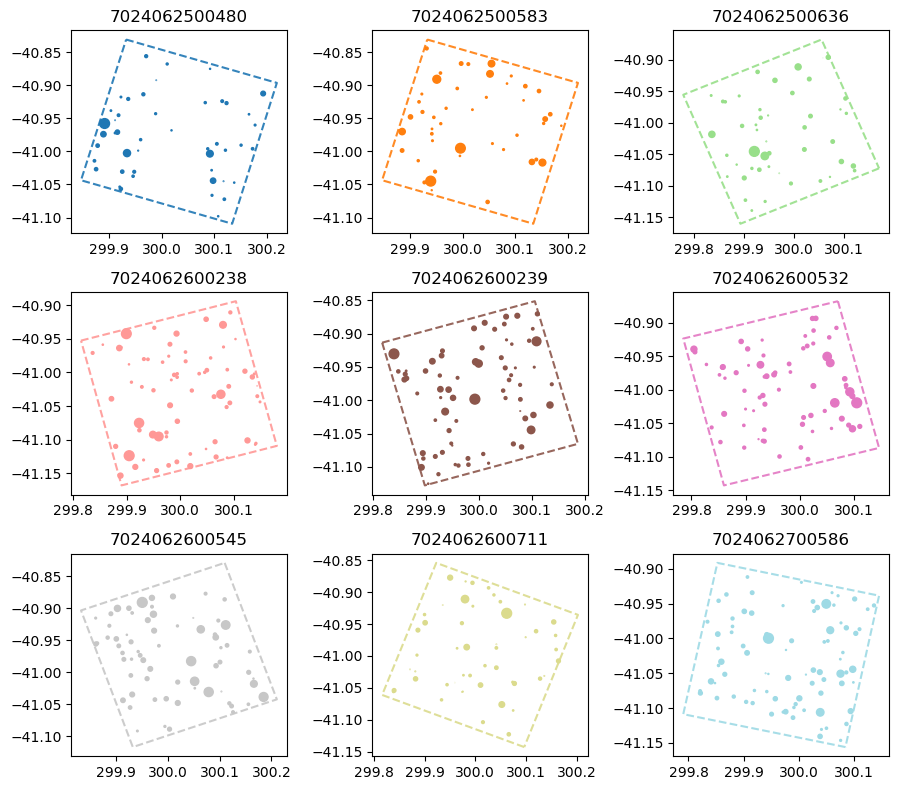

In [118]:
colors = plt.cm.tab20(np.linspace(0, 1, len(summ_df)))

fig, axes = plt.subplots(3, 3, figsize=(9,8))
for irow, arow in summ_df.iterrows():    
    ax = axes.flatten()[irow]
    verts = (
        [arow['ccd_corner_1_ra'], arow['ccd_corner_1_dec']],
        [arow['ccd_corner_2_ra'], arow['ccd_corner_2_dec']],
        [arow['ccd_corner_3_ra'], arow['ccd_corner_3_dec']],
        [arow['ccd_corner_4_ra'], arow['ccd_corner_4_dec']],
        [arow['ccd_corner_1_ra'], arow['ccd_corner_1_dec']]   # repeat to close loop
    )

    rough_center = np.mean(np.array(verts), axis=0)

    xs, ys = zip(*verts)
    ax.plot(xs, ys, '--', color=colors[irow], alpha=0.9)
    ax.set_title(arow['visit'])
    #ax.text(arow['ccd_corner_1_ra'], arow['ccd_corner_1_dec'], arow['visit'], alpha=1)
    visitFakes = fakeCat[fakeCat.visit==arow['visit']]
    sizes = (visitFakes['mag'] - visitFakes['mag'].max())/(visitFakes['mag'].max() - visitFakes['mag'].min())
    ax.scatter(visitFakes['ra'], visitFakes['dec'], c=colors[irow], s=50*sizes**2)

plt.tight_layout()

(array([  6.,   9.,  17.,  16.,  19.,  82., 165., 162.,  66.,  14.]),
 array([14.51618159, 15.75781237, 16.99944315, 18.24107393, 19.48270471,
        20.72433549, 21.96596627, 23.20759706, 24.44922784, 25.69085862,
        26.9324894 ]),
 <BarContainer object of 10 artists>)

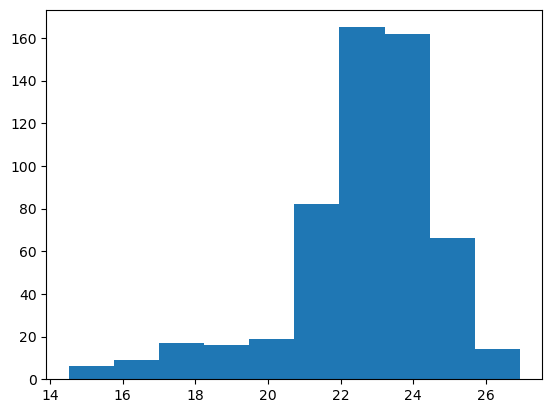

In [119]:
plt.hist(fakeCat.mag)

In [120]:
fakeCat.to_csv('fakeCatalog_OR4Test.csv', index=False)

In [62]:
from lsst.source.injection import ingest_injection_catalog

In [121]:
# ingest the catalog into the butler collection

# ingest_injection_catalog -b embargo_new \
#     -i fakeCatalog_OR4Test.csv r \
#     -o YourCollectionNameHere
